In [106]:
import os 
from PIL import Image
import csv
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
import shutil
import random
import numpy as np

## Exploratory data analysis

#### Process 
* Define the path of input/output
* Show the bounding box and the data we will be using

In [2]:
yolov3 = 'yolov3'
detect = 'detect.py'
train = 'train.py'

In [43]:
bboxes_path = 'images/train_solution_bounding_boxes.csv'
data_path = os.path.join(yolov3,'data')
train_img_path = os.path.join(data_path,'images')
label_path = os.path.join(data_path,'labels')
test_img_path = os.path.join(data_path, 'testing_images')

In [4]:
bboxes = pd.read_csv(bboxes_path)

In [5]:
bboxes.head(10)

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_10000.jpg   15.163531  187.035071  120.329957  236.430180
2  vid_4_10040.jpg  239.192475  176.764801  361.968162  236.430180
3  vid_4_10020.jpg  496.483358  172.363256  630.020260  231.539575
4  vid_4_10060.jpg   16.630970  186.546010  132.558611  238.386422
5  vid_4_10100.jpg  447.568741  160.625804  582.083936  232.517696
6  vid_4_10120.jpg  168.755427  180.677284  304.738061  246.700450
7  vid_4_10140.jpg    0.000000  188.991313   85.111433  249.145753
8   vid_4_1020.jpg  202.506512  189.480373  239.192475  229.094273
9   vid_4_1040.jpg  116.416787  189.969434  180.494935  229.094273

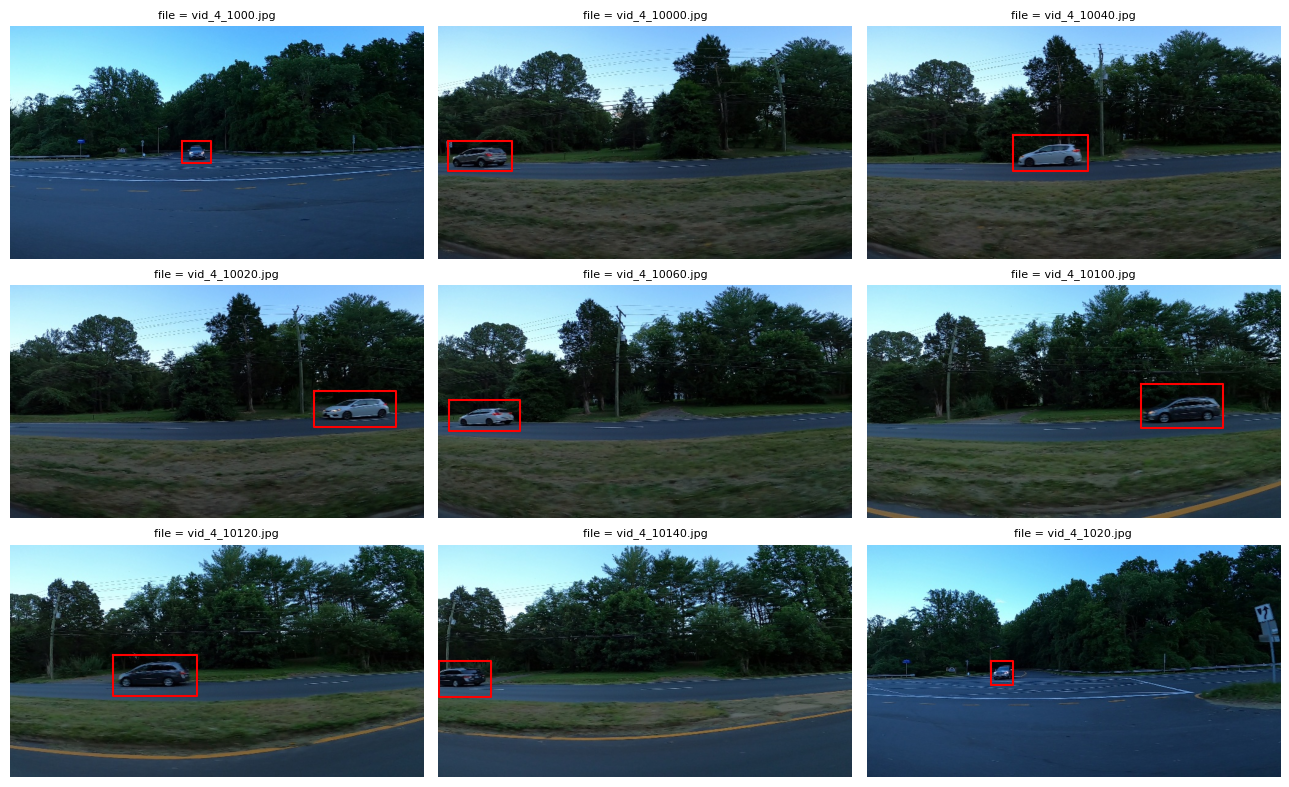

In [64]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(13, 8))

axes = axes.flatten()
for k, ax in zip(range(0, 9), axes):    
        target = bboxes.iloc[k]
        img = plt.imread(os.path.join(train_img_path,target["image"]))
        ax.imshow(img)
        ax.set_title(f'file = {target["image"]}', fontsize=8)
        ax.axis('off')

        ax.plot([target["xmin"], target["xmax"], target["xmax"], target["xmin"], target["xmin"]],
         [target["ymin"], target["ymin"], target["ymax"], target["ymax"], target["ymin"]], c="r")

plt.tight_layout()
plt.show()

This is how it should look by applying the bounding box to the image.

## Preprocessing

#### Process

* Convert the bounding box csv file into yolo compatible format.
* Save the list of train/ test sets in as a single file. 

In [35]:
train_images_path = os.path.join(train_img_path, 'train')
val_images_path = os.path.join(train_img_path, 'val')

# list all files in the training images directory
for file_name in os.listdir(train_img_path):
    if file_name.endswith('.jpg'):
        # add image file path to train_images list
        # 80% to train 20% to validation

        source_file = os.path.join(train_img_path, file_name)

        rand_num = random.random()  # Random number between 0 and 1
        if rand_num <= 0.8:
            shutil.move(source_file, train_images_path)
        else:
            shutil.move(source_file, val_images_path)


In [44]:

train_path = os.path.join(train_img_path, 'train')
val_path = os.path.join(train_img_path, 'val')
train_label_path = os.path.join(label_path, 'train')
val_label_path = os.path.join(label_path, 'val')

In [45]:
val_label_path

'yolov3\\data\\labels\\val'

In [46]:
def convert_csv_to_yolo(csv_file_path):
    with open(csv_file_path, 'r') as csv_file:
        reader = csv.DictReader(csv_file)
        for row in reader:
            image_name = row['image']
            class_id = 0
            x_min, y_min, x_max, y_max = map(float, [row['xmin'], row['ymin'], row['xmax'], row['ymax']])
            
            # get image dimensions
            img_path = os.path.join(train_path, image_name)
            if os.path.isfile(img_path):
                with Image.open(img_path) as img:
                    image_width, image_height = img.width, img.height

               # convert to YOLO format
                x_center = ((x_min + x_max) / 2) / image_width
                y_center = ((y_min + y_max) / 2) / image_height
                width = (x_max - x_min) / image_width
                height = (y_max - y_min) / image_height

                txt_file_path = os.path.join(train_label_path, os.path.splitext(image_name)[0] + '.txt')
                with open(txt_file_path, 'a', newline='\n') as txt_file:
                    txt_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

                txt_file_path = os.path.join(train_path, os.path.splitext(image_name)[0] + '.txt')
                with open(txt_file_path, 'a', newline='\n') as txt_file:
                    txt_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")
                    
            else:
                img_path = os.path.join(val_path, image_name)
                with Image.open(img_path) as img:
                    image_width, image_height = img.width, img.height

                 # convert to YOLO format
                x_center = ((x_min + x_max) / 2) / image_width
                y_center = ((y_min + y_max) / 2) / image_height
                width = (x_max - x_min) / image_width
                height = (y_max - y_min) / image_height

                txt_file_path = os.path.join(val_label_path, os.path.splitext(image_name)[0] + '.txt')
                with open(txt_file_path, 'a', newline='\n') as txt_file:
                    txt_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

                txt_file_path = os.path.join(val_path, os.path.splitext(image_name)[0] + '.txt')
                with open(txt_file_path, 'a', newline='\n') as txt_file:
                    txt_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

In [47]:
convert_csv_to_yolo(bboxes_path)

In [48]:
def gen_dummies():
    for file_name in os.listdir(train_path):
        if file_name.endswith('.jpg'):
            annotate = os.path.splitext(file_name)[0] + '.txt'
            annotate_path = os.path.join(train_path, annotate)

            if not os.path.isfile(annotate_path):
                with open(annotate_path, 'w', newline='\n') as txt_file:
                    pass

                with open(os.path.join(train_label_path, annotate), 'w', newline='\n') as txt_file:
                    pass

    for file_name in os.listdir(val_path):
        if file_name.endswith('.jpg'):
            annotate = os.path.splitext(file_name)[0] + '.txt'
            annotate_path = os.path.join(val_path, annotate)

            if not os.path.isfile(annotate_path):
                with open(annotate_path, 'w', newline='\n') as txt_file:
                    pass

                with open(os.path.join(val_label_path, annotate), 'w', newline='\n') as txt_file:
                    pass


In [55]:
import random

def gen_train():
    train_images = []
    val_images = []

    # list all files in the training images directory
    for file_name in os.listdir(train_path):
        if file_name.endswith('.jpg'):
            # add image file path to train_images list
            train_images.append(os.path.join('data/images/train/', file_name))

    for file_name in os.listdir(val_path):
        if file_name.endswith('.jpg'):
            # add image file path to train_images list
            val_images.append(os.path.join('data/images/val/', file_name))

    text_path = os.path.join(data_path, "train.txt")
    with open(text_path, "w", newline='\n') as outfile:
        for image in train_images:
            outfile.write(f'{image}\n')
        outfile.close() 

    text_path = os.path.join(data_path, "val.txt")
    with open(text_path, "w", newline='\n') as outfile:
        for image in val_images:
            outfile.write(f'{image}\n')
        outfile.close() 

In [50]:
def gen_test():
    test_images = []

    for file_name in os.listdir(test_img_path):
        if file_name.endswith('.jpg'):
            test_images.append('data/testing_images/' + file_name)

    text_path = os.path.join(data_path, "test.txt")
    with open(text_path, "w", newline='\n') as outfile:
        for image in test_images:
            outfile.write(f'{image}\n')
        outfile.close()

In [51]:
gen_dummies()

In [56]:
gen_train()


In [53]:
gen_test()

## Run YOLOv3

training with command 

python train.py --img 640 --batch 16 --epochs 20 --data detection.yml

In [89]:
#detection.yml:
'''
train: data/train.txt
val: data/val.txt

# number of classes
nc: 1

# class names
names: ['car']
'''

"\ntrain: data/train.txt\nval: data/val.txt\n\n# number of classes\nnc: 1\n\n# class names\nnames: ['car']\n"

In [87]:
command = ['python', train, '--img',  '640', '--batch', '16', '--epochs', '20', '--data', 'detection.yml']

In [68]:

process = subprocess.run(command, cwd=yolov3, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

print(process.stdout)
print(process.stderr)

Exception in thread Thread-15 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\aky20\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\aky20\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\aky20\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "c:\Users\aky20\AppData\Local\Programs\Python\Python311\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8d in position 6187: character maps to <undefined>



None


I used 810 images as training set and 191 images as validation set.

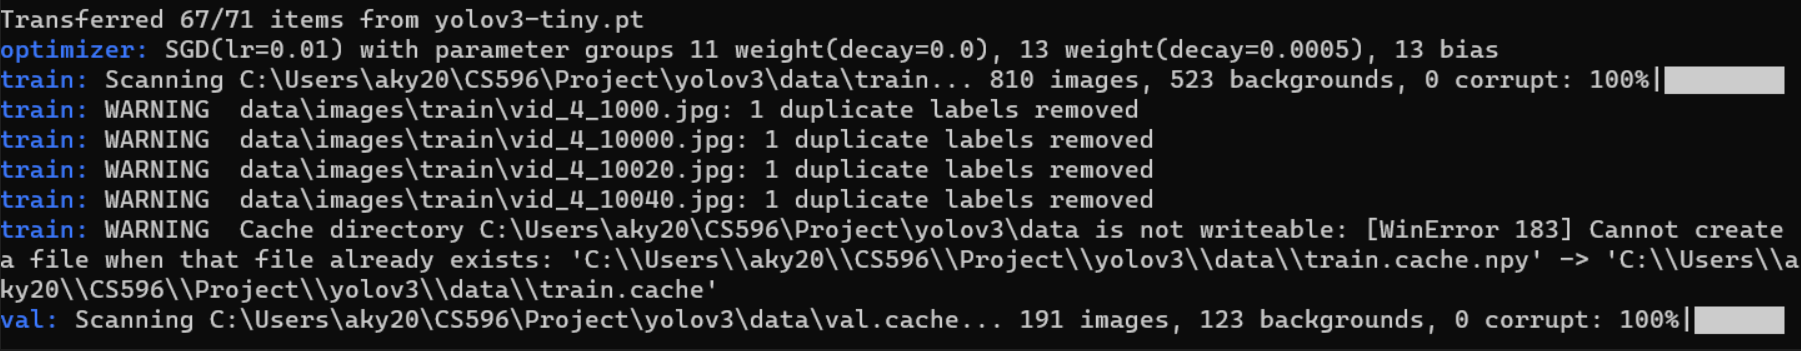
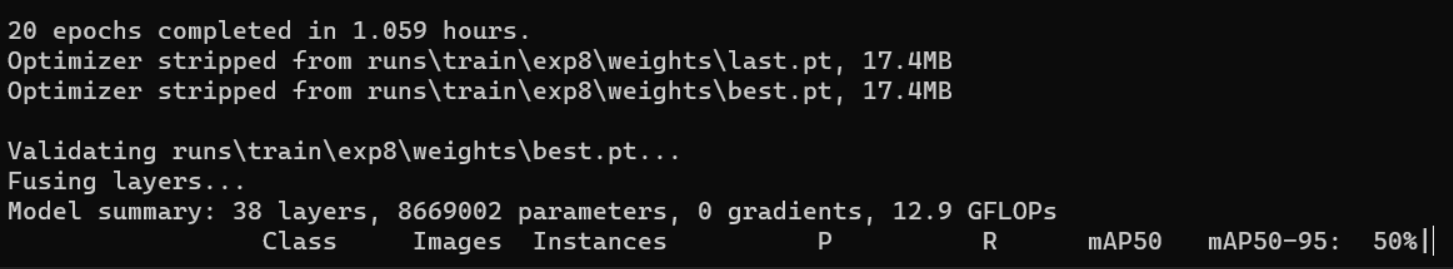

I attached the image of the process as it took very long.

For the same reason, I ran through 20 runs for training.

## Evaluation

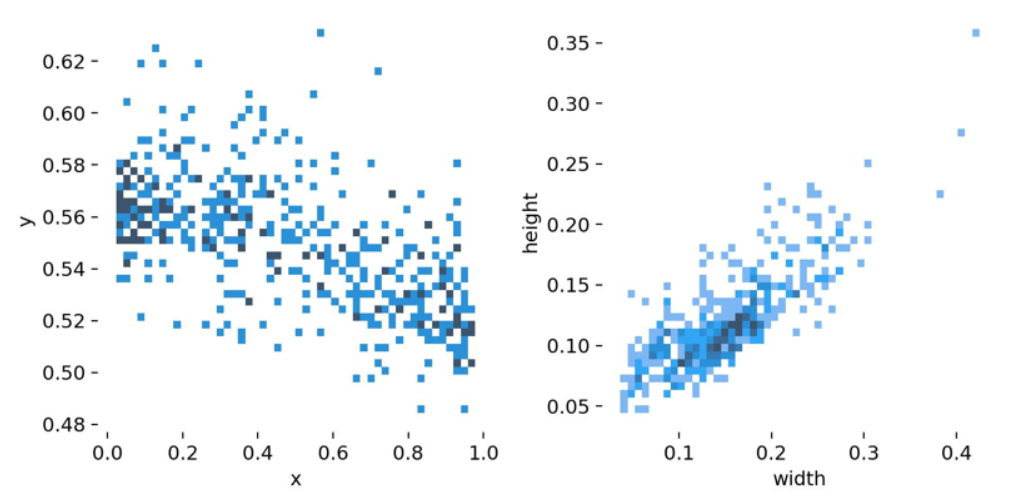
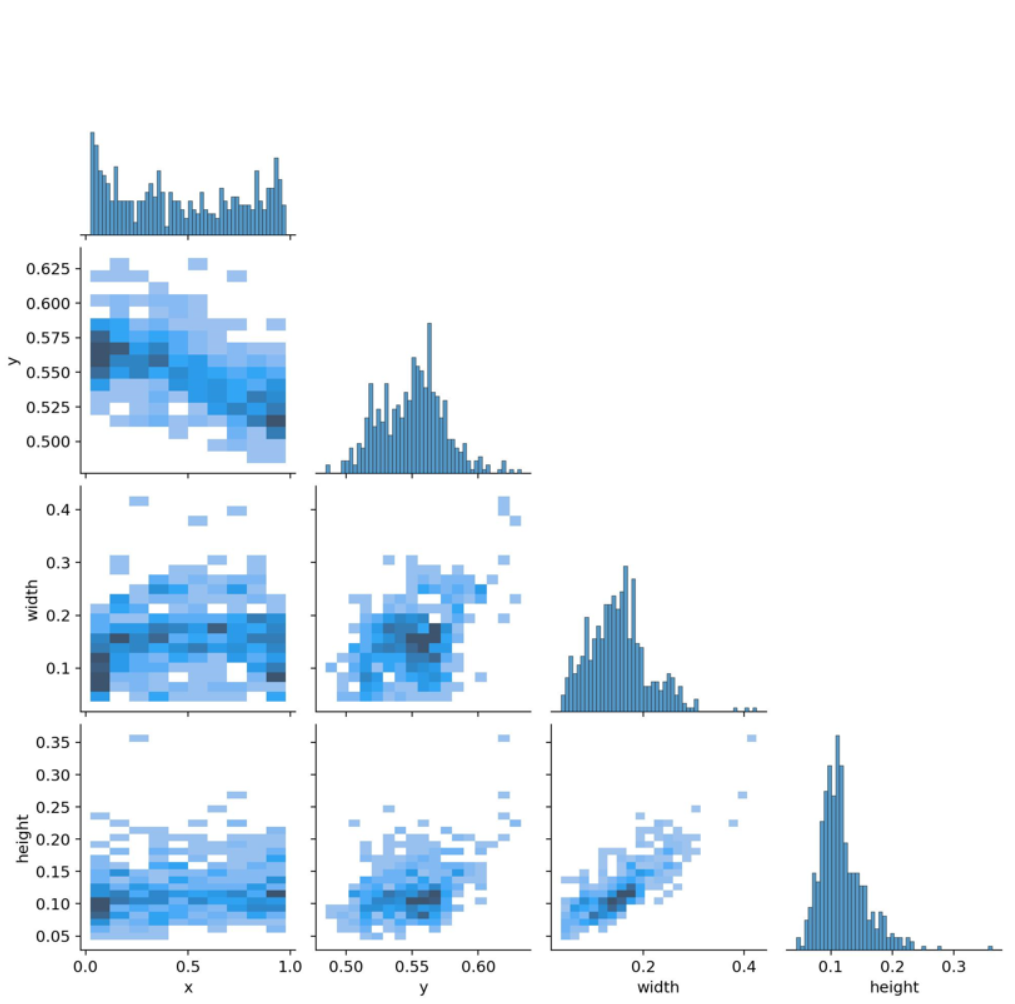

The application derived a scatter plot and a pair plot.

These graphs shows the distribution of object positions and sizes within the dataset.

The x vs y scatter plot, where x and y are normalized center positions, shows the horizontal position of bounding boxes relates to their virtical position.

It is observable that there is a higher density towards both extreme points of the x axis, which suggests that objects are more commonly found near the right and left edges of the image.

Based on the dataset samples we saw above, it is very convincing.

In both graphs, we can see that most of the objects have smaller widths and heights, with very few large objects. 

This indicates that the dataset contains many small or distant objects.


In [74]:
trained_data_path = os.path.join(yolov3, 'runs/train/exp8/')

In [75]:
results = pd.read_csv(os.path.join(trained_data_path, 'results.csv'))

In [76]:
results.describe()

epoch        train/box_loss        train/obj_loss  \
count              20.00000             20.000000             20.000000   
mean                9.50000              0.047571              0.015765   
std                 5.91608              0.018889              0.006924   
min                 0.00000              0.029970              0.011400   
25%                 4.75000              0.034459              0.012613   
50%                 9.50000              0.040960              0.013359   
75%                14.25000              0.054081              0.015737   
max                19.00000              0.097837              0.042238   

             train/cls_loss     metrics/precision        metrics/recall  \
count             20.000000             20.000000             20.000000   
mean               0.001730              0.845514              0.892235   
std                0.002146              0.226380              0.136551   
min                0.000427              0.232880              0.520830   
25%                0.000666              0.787925              0.838507   
50%                0.001085              0.964980              0.968685   
75%                0.001918              0.988433              0.976123   
max                0.010226              0.989470              0.979170   

            metrics/mAP_0.5  metrics/mAP_0.5:0.95          val/box_loss  \
count             20.000000             20.000000             20.000000   
mean               0.869489              0.447214              0.043430   
std                0.214410              0.171815              0.015274   
min                0.196660              0.046258              0.029541   
25%                0.882350              0.346562              0.033851   
50%                0.974960              0.525560              0.037422   
75%                0.981925              0.564840              0.052356   
max                0.984960              0.618340              0.080320   

               val/obj_loss          val/cls_loss                 x/lr0  \
count             20.000000             20.000000             20.000000   
mean               0.011075              0.001198              0.010290   
std                0.002905              0.000624              0.016388   
min                0.009138              0.000482              0.001090   
25%                0.009363              0.000683              0.003441   
50%                0.010162              0.001068              0.005792   
75%                0.010821              0.001501              0.008144   
max                0.021054              0.002661              0.070588   

                      x/lr1                 x/lr2  
count             20.000000             20.000000  
mean               0.005192              0.005192  
std                0.002469              0.002469  
min                0.001090              0.001090  
25%                0.003219              0.003219  
50%                0.005298              0.005298  
75%                0.007154              0.007154  
max                0.008951              0.008951

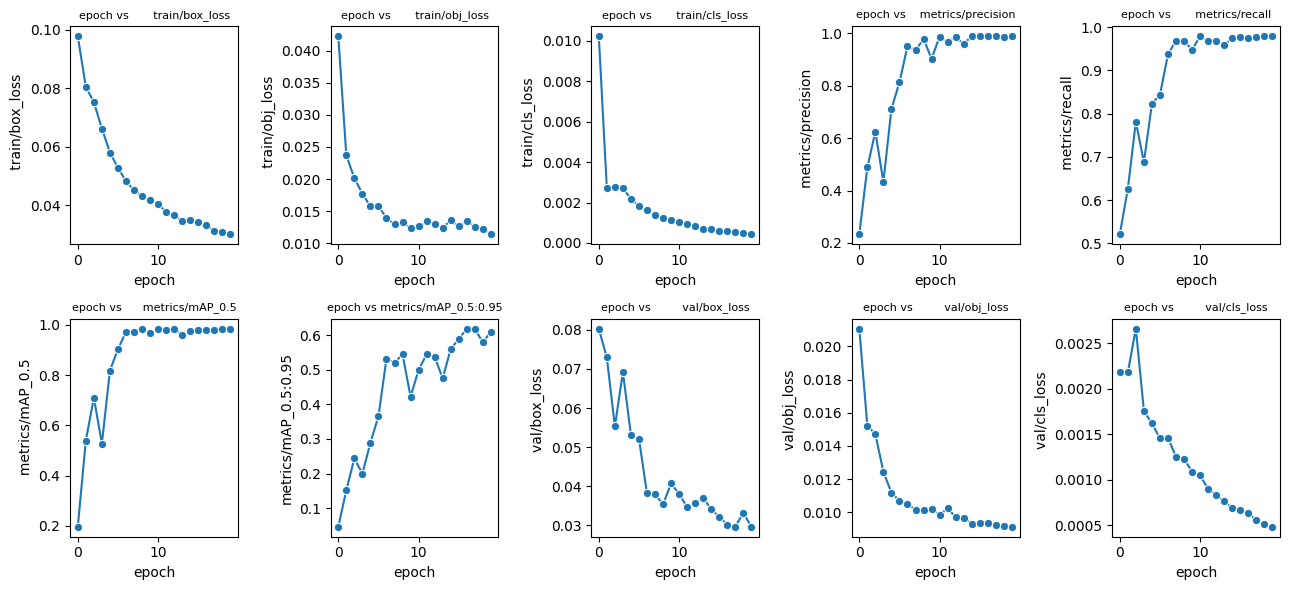

In [88]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (13, 6))
axes = axes.flatten()
from itertools import islice
import seaborn as sns

for i, ax in islice(enumerate(axes[:len(results.columns)]), 10):
    col_name = results.columns[i + 1]
    ax = sns.lineplot(data = results, x=results.columns[0], y=results[col_name], marker='o', ax=ax)

    ax.set_title(f'epoch vs {col_name}',fontsize = 8)
    ax.set_xlabel('epoch')
    ax.set_ylabel(col_name)
    #sns.regplot(data = results, x=results.columns[0], y = results[col_name], scatter = False, ax = ax, color='red')

plt.subplots_adjust(hspace = 0.5, wspace = 4)  
plt.tight_layout()
plt.show()

The result was printed out on completion.

according to the box losses in both train and val, they both showed decrement over epochs. It indicates that the model is learning to predict the correct location and size of the bounding boxes over tries.

Although both graphs decreased over epoch, train graph was more stable than the validation graph. This is most likely because the size of the training set is much larger than the validation set.

The objectness in both train and val graph also decreased over epoch. Objectness loss graph represents how well the model predicts the presence of an object within the bounding box. 

As the loss value gets lower, it suggests that the model is confident in its predictions of whether a box contains an object.

Classification losses indicates the error in predicting the correct class for the objects detected. Since we only have one class in the trained weight, the object may not be detected, but it cannot be misclassified.

The precision, recall, and mean average precision at an intersection over Union (IoU) threshold of 0.5, the graph skyrocketed at the beginning, but starting from around 10 epochs, it started to get stabilized.

The last plot shows the mean average precision calculated over multiple IoU thresholds from 0.5 to 0.95 from where the objects are half way overlapped to nearly almost overlapped.

Although it is showing some fluctuations, it is steadily showing improvements.

In [78]:
command = ['python', detect, '--weights', 'runs/train/exp8/weights/best.pt', '--img',  '640', '--conf', '0.25', '--source', 'data/testing_images']
process = subprocess.run(command, cwd=yolov3, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

print(process.stdout)
print(process.stderr)



detect: weights=['runs/train/exp8/weights/best.pt'], source=data/testing_images, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv3  v9.6.0-137-gc6acbdda Python-3.11.5 torch-2.1.1+cpu CPU

Fusing layers... 
Model summary: 38 layers, 8669002 parameters, 0 gradients, 12.9 GFLOPs
image 1/175 C:\Users\aky20\CS596\Project\yolov3\data\testing_images\vid_5_25100.jpg: 384x640 (no detections), 47.1ms
image 2/175 C:\Users\aky20\CS596\Project\yolov3\data\testing_images\vid_5_25120.jpg: 384x640 (no detections), 45.4ms
image 3/175 C:\Users\aky20\CS596\Project\yolov3\data\testing_images\vid_5_25140.jpg: 384x640 (no detections), 45.1ms
image 4/175 C:\User

In [90]:
command = ['python', detect, '--weights', 'yolov3.pt', '--img',  '640', '--conf', '0.25', '--source', 'data/testing_images']
process = subprocess.run(command, cwd=yolov3, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

print(process.stdout)
print(process.stderr)



detect: weights=['yolov3.pt'], source=data/testing_images, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv3  v9.6.0-137-gc6acbdda Python-3.11.5 torch-2.1.1+cpu CPU

Fusing layers... 
yolov3 summary: 261 layers, 61922845 parameters, 0 gradients, 155.9 GFLOPs
image 1/175 C:\Users\aky20\CS596\Project\yolov3\data\testing_images\vid_5_25100.jpg: 384x640 (no detections), 246.2ms
image 2/175 C:\Users\aky20\CS596\Project\yolov3\data\testing_images\vid_5_25120.jpg: 384x640 (no detections), 250.1ms
image 3/175 C:\Users\aky20\CS596\Project\yolov3\data\testing_images\vid_5_25140.jpg: 384x640 (no detections), 249.9ms
image 4/175 C:\Users\aky20\CS596\P

In [103]:
def extract_time(timeline_path):
    extracted_numbers = []
    with open(timeline_path, 'r') as file:
        for line in file:
            if 'ms' in line:
                # find the index of 'ms'
                line_parts = line.split()
                for part in line_parts:
                    if 'ms' in part:
                        # Remove 'ms' and any other non-numeric characters
                        time_str = ''.join(filter(str.isdigit, part))
                        try:
                            extracted_numbers.append(float(time_str))
                        except ValueError:
                            pass

    return extracted_numbers

In [107]:
custom_timeline = np.array(extract_time('custom_time.txt'))
built_timeline = np.array(extract_time('built_time.txt'))

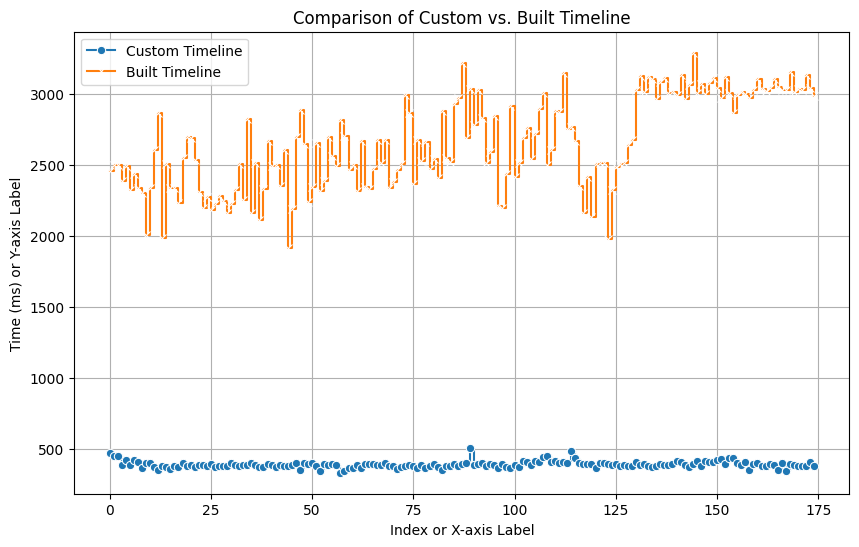

In [109]:
x_values = np.arange(len(custom_timeline))
fig, ax = plt.subplots(figsize = (10, 6))  
ax = sns.lineplot(x=x_values, y=custom_timeline, marker='o', drawstyle="steps-post", ax=ax, label='Custom Timeline')
ax = sns.lineplot(x=x_values, y=built_timeline, marker='x', drawstyle="steps-post", ax=ax, label='Built Timeline')

ax.set_title('Comparison of Custom vs. Built Timeline')
ax.set_xlabel('Index or X-axis Label')
ax.set_ylabel('Time (ms) or Y-axis Label')
plt.grid(True)
plt.show()

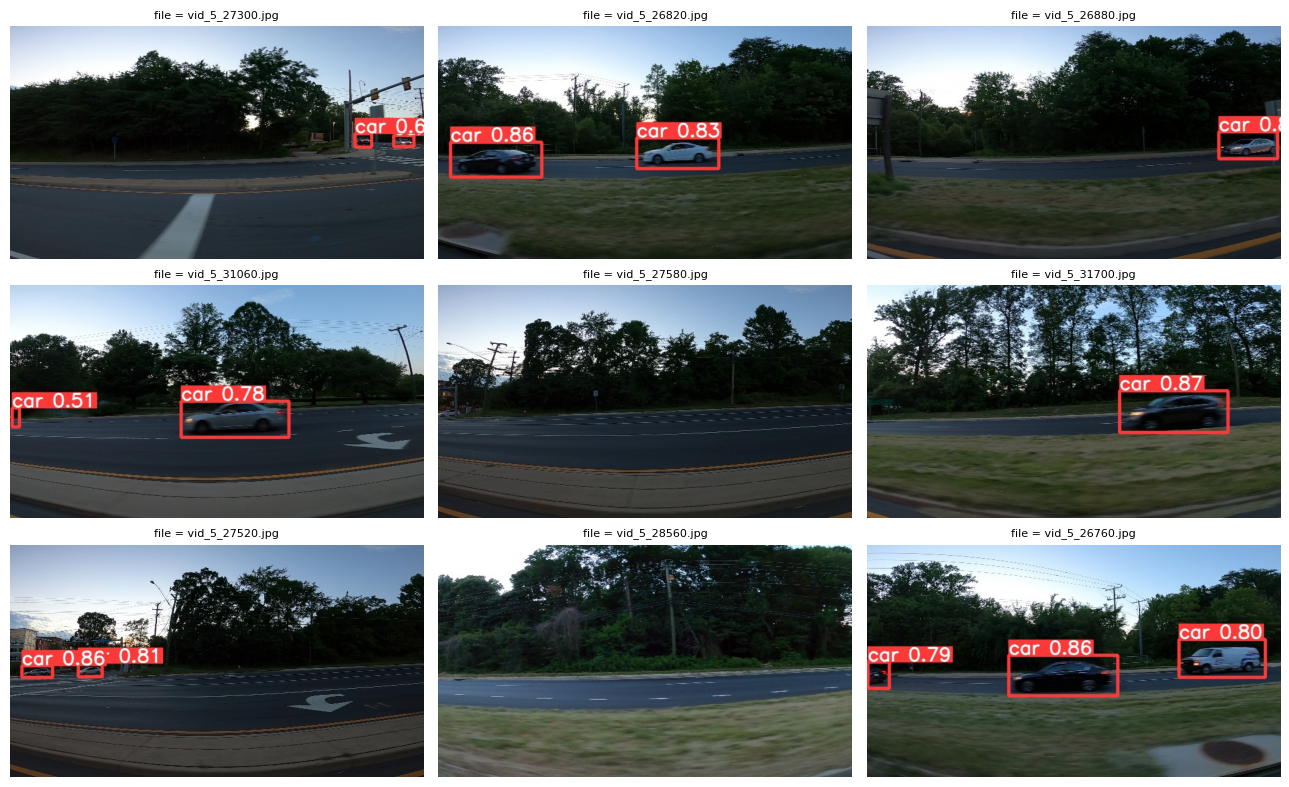

In [84]:
result_img_path = os.path.join(yolov3, 'runs\detect\exp7')
compare_img_path = os.path.join(yolov3, 'runs\detect\exp8')

all_images = os.listdir(result_img_path)
random_images = random.sample(all_images, 9)
compare_images = []

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(13, 8))
axes = axes.flatten()

for k, ax in zip(range(0, 9), axes):    
    # read the kth image in the path
    random_path = os.path.join(result_img_path, random_images[k])
    compare_images.append(os.path.join(compare_img_path, random_images[k]))
    
    img = plt.imread(random_path)
    ax.imshow(img)
    ax.set_title(f'file = {random_images[k]}', fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

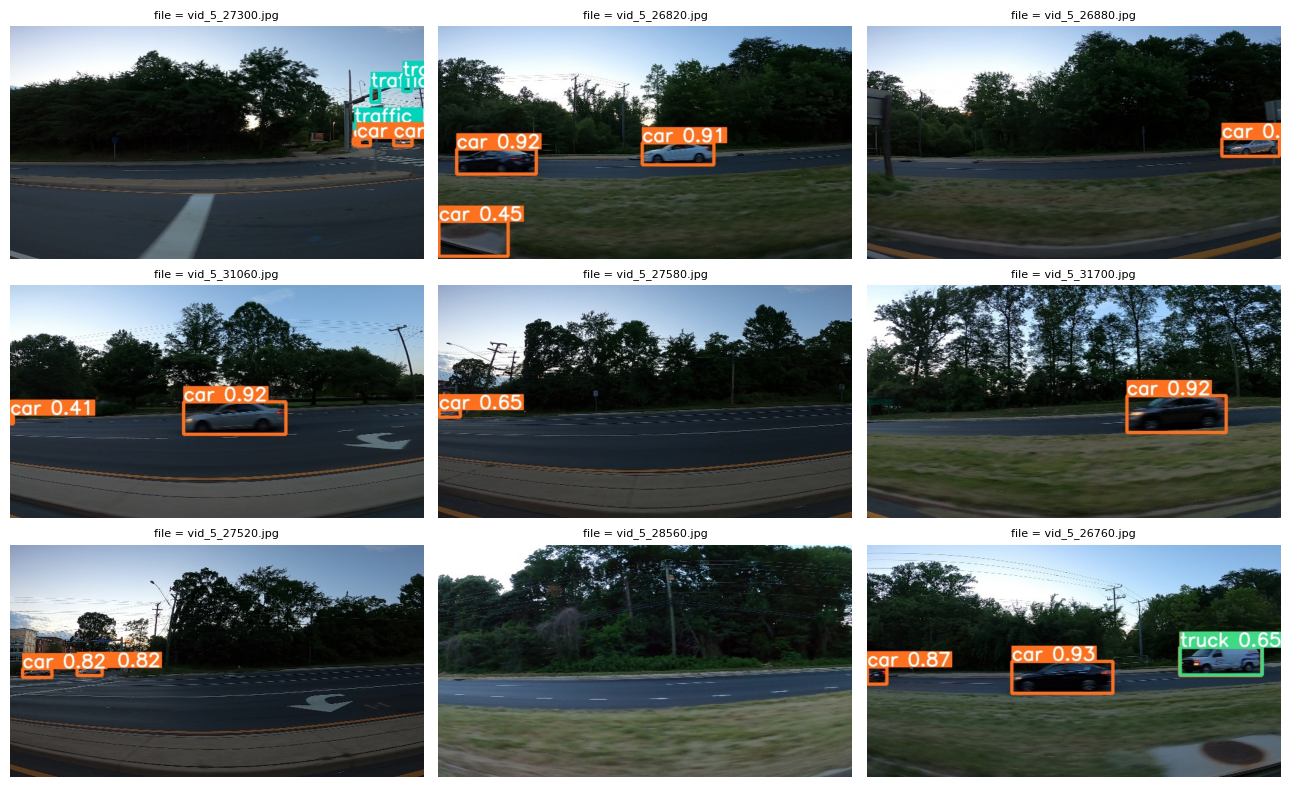

In [86]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(13, 8))
axes = axes.flatten()

for k, ax in zip(range(0, 9), axes):    
    img = plt.imread(compare_images[k])
    ax.imshow(img)
    ax.set_title(f'file = {random_images[k]}', fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

The prediction using custom weights did manage to detect the objects and placed bounding boxes in the right position, but showed relatively low confidence scores in overall.

It was quite accurate based on the fact that there were no false negatives and false positives.

On the other hand, the prediction using YOLOv3 pre-trained weights showed relatively higher confidence score with one false positive with the lowest certainty.

The main difference would be that the pre-trained model showed more accuracy in placing the bounding boxes, showing tighter area within the box.

## Conclusion

The pre-trained YOLOv3 model seems to provide more precise and tighter bounding boxes compared to the custom model. In other words, it had better localization ability.

In overall, the confidence scores in pre-trained model showed higher values, which suggests that it has likely been trained on a larger, more diverse dataset, making it more powerful against changes in object appearance and background.

Considering the observations, the pre-trained YOLOv3 weights may be more suitable in diverse environments. However, for specialized tasks where the conditions are well-known and consistent, a fine-tuned custom model for specific domains potentially derives better results, despite the loose bounding boxes observed in these specific images.  

This specific project shows that the time took in predicting using pre-trained weight was from about 5 times to 9 times prediction using custom weight. For faster prediction, it can be a good idea to focus on target objects.

In real-world problems, the choice between whether to use the pre-trained model or to train a custom model depends on specific requirements of the task at hand, including how specific, controlled environment the context is.

Various metrics should be used for the best assessment.